In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


def set_all_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
seed = 0
set_all_seed(seed=seed)

Using device: cuda


In [5]:
# Paths
# TRAIN_DIR = './cosmic-curator/train_images'
# TEST_DIR = './cosmic-curator/test_images'
# TRAIN_CSV = './cosmic-curator/train2.csv'

TRAIN_DIR = '/kaggle/input/cosmic-curator/train_images_updated/train_images_updated'
TEST_DIR = '/kaggle/input/cosmic-curator/test_images/test_images'
TRAIN_CSV = '/kaggle/input/cosmic-curator/train_images_updated.csv'
OUT_DIR = './results'
if os.path.exists(OUT_DIR):
    import shutil
    shutil.rmtree(OUT_DIR)
# create directory
os.makedirs(OUT_DIR, exist_ok=True)
OUT_TRAIN_CSV = os.path.join(OUT_DIR, 'train.csv')
OUT_TEST_CSV = os.path.join(OUT_DIR, 'test.csv')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
BATCH_SIZE = 32
# BATCH_SIZE = 16
NUM_CLASSES = 3
NUM_EPOCHS = 50
LEARNING_RATE = 3e-5
IMG_SIZE = 424
VAL_SPLIT = 0.2
SAVE_CHECKPOINT = True

In [ ]:
# --- Custom Dataset ---
class GalaxyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        asset_id = self.df.loc[idx, 'asset_id']
        img_path = os.path.join(self.img_dir, f"{asset_id}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, asset_id
        else:
            label = int(self.df.loc[idx, 'GalaxyType'])
            return image, label

# # --- Transforms ---
# # Resnet Transforms
# train_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(30),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# test_transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# # SwinT Transforms
weights = models.Swin_T_Weights.DEFAULT
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [7]:
# --- Load CSV ---
train_df = pd.read_csv(TRAIN_CSV)
print("Images in train set:", len(train_df))
# delete the images that are not in the train set
train_img_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TRAIN_DIR) if f.endswith('.jpg')]
train_df = train_df[train_df['asset_id'].isin(train_img_asset_ids)]
train_df = train_df.reset_index(drop=True)

test_asset_ids = [int(f.split('.')[0]) for f in os.listdir(TEST_DIR) if f.endswith('.jpg')]
test_df = pd.DataFrame({'asset_id': test_asset_ids})
print("Images in test set:", len(test_df))


# --- Train/Val Split ---
train_df, val_df = train_test_split(train_df, test_size=VAL_SPLIT, stratify=train_df['GalaxyType'], random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print("After splitting into train and val sets:")
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Images in train set: 5994
Images in test set: 412
After splitting into train and val sets:
Train size: 4795
Val size: 1199
Test size: 412


In [8]:
# class counts
print("Train class counts:")
print(train_df['GalaxyType'].value_counts())
print("Val class counts:")
print(val_df['GalaxyType'].value_counts())

Train class counts:
GalaxyType
2    2624
0    1455
1     716
Name: count, dtype: int64
Val class counts:
GalaxyType
2    656
0    364
1    179
Name: count, dtype: int64


In [9]:
train_dataset = GalaxyDataset(train_df, TRAIN_DIR, transform=train_transform)
val_dataset = GalaxyDataset(val_df, TRAIN_DIR, transform=test_transform)
test_dataset = GalaxyDataset(test_df, TEST_DIR, transform=test_transform, is_test=True)
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset)) 
print("Test dataset size:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))
print("Test loader size:", len(test_loader))

Train dataset size: 4795
Validation dataset size: 1199
Test dataset size: 412
Train loader size: 150
Validation loader size: 38
Test loader size: 13


In [10]:
# --- Model ---
# # model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

weights = models.Swin_T_Weights.DEFAULT
model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 92.4MB/s] 


In [11]:
# --- Training Loop ---
# Initialize lists to store F1 scores
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []

best_val_f1 = 0.0  # To track the best validation F1 score
best_model_path = os.path.join(OUT_DIR, 'best_model.pth')

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_preds, train_labels = [], []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_f1 = f1_score(train_labels, train_preds, average='macro')
    train_f1_scores.append(train_f1)
    train_losses.append(train_loss / len(train_loader))  # Average train loss

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_labels, val_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_losses.append(val_loss / len(val_loader))  # Average validation loss

    print(f"Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, Train F1={train_f1:.4f}, Val Loss={val_losses[-1]:.4f}, Val F1={val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Best model saved with Val F1={best_val_f1:.4f}")

    # Save checkpoint for each epoch if enabled
    # if SAVE_CHECKPOINT and (epoch + 1) % 5 == 0:
    if SAVE_CHECKPOINT:
        checkpoint_path = os.path.join(OUT_DIR, f"model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)

Epoch 1 [Val]: 100%|██████████| 38/38 [00:26<00:00,  1.43it/s]


Epoch 1: Train Loss=0.7456, Train F1=0.5791, Val Loss=0.6184, Val F1=0.6841
✅ Best model saved with Val F1=0.6841


Epoch 2 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 2: Train Loss=0.5960, Train F1=0.6913, Val Loss=0.5800, Val F1=0.6567


Epoch 3 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 3: Train Loss=0.5553, Train F1=0.7295, Val Loss=0.5708, Val F1=0.7170
✅ Best model saved with Val F1=0.7170


Epoch 4 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 4: Train Loss=0.5260, Train F1=0.7398, Val Loss=0.5375, Val F1=0.7215
✅ Best model saved with Val F1=0.7215


Epoch 5 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 5: Train Loss=0.5158, Train F1=0.7386, Val Loss=0.5192, Val F1=0.7354
✅ Best model saved with Val F1=0.7354


Epoch 6 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 6: Train Loss=0.4872, Train F1=0.7606, Val Loss=0.5670, Val F1=0.7164


Epoch 7 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 7: Train Loss=0.4752, Train F1=0.7687, Val Loss=0.5126, Val F1=0.7466
✅ Best model saved with Val F1=0.7466


Epoch 8 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 8: Train Loss=0.4695, Train F1=0.7735, Val Loss=0.5128, Val F1=0.7528
✅ Best model saved with Val F1=0.7528


Epoch 9 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.02it/s]


Epoch 9: Train Loss=0.4526, Train F1=0.7748, Val Loss=0.5262, Val F1=0.7314


Epoch 10 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 10: Train Loss=0.4290, Train F1=0.7859, Val Loss=0.5201, Val F1=0.7490


Epoch 11 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 11: Train Loss=0.4263, Train F1=0.7885, Val Loss=0.5313, Val F1=0.7497


Epoch 12 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 12: Train Loss=0.4143, Train F1=0.7994, Val Loss=0.5300, Val F1=0.7350


Epoch 13 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 13: Train Loss=0.3995, Train F1=0.8128, Val Loss=0.5710, Val F1=0.7396


Epoch 14 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.04it/s]


Epoch 14: Train Loss=0.3947, Train F1=0.8136, Val Loss=0.5696, Val F1=0.7607
✅ Best model saved with Val F1=0.7607


Epoch 15 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


Epoch 15: Train Loss=0.3679, Train F1=0.8228, Val Loss=0.5938, Val F1=0.7429


Epoch 16 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 16: Train Loss=0.3542, Train F1=0.8384, Val Loss=0.6133, Val F1=0.7426


Epoch 17 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 17: Train Loss=0.3511, Train F1=0.8311, Val Loss=0.5785, Val F1=0.7506


Epoch 18 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 18: Train Loss=0.3337, Train F1=0.8473, Val Loss=0.5929, Val F1=0.7353


Epoch 19 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 19: Train Loss=0.3256, Train F1=0.8445, Val Loss=0.5468, Val F1=0.7490


Epoch 20 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 20: Train Loss=0.3074, Train F1=0.8605, Val Loss=0.6636, Val F1=0.7461


Epoch 21 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 21: Train Loss=0.3014, Train F1=0.8616, Val Loss=0.6916, Val F1=0.7156


Epoch 22 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 22: Train Loss=0.2831, Train F1=0.8680, Val Loss=0.7216, Val F1=0.7461


Epoch 23 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 23: Train Loss=0.2716, Train F1=0.8782, Val Loss=0.6664, Val F1=0.7662
✅ Best model saved with Val F1=0.7662


Epoch 24 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 24: Train Loss=0.2728, Train F1=0.8716, Val Loss=0.6628, Val F1=0.7597


Epoch 25 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 25: Train Loss=0.2575, Train F1=0.8832, Val Loss=0.7529, Val F1=0.7373


Epoch 26 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.05it/s]


Epoch 26: Train Loss=0.2442, Train F1=0.8868, Val Loss=0.7316, Val F1=0.7247


Epoch 27 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 27: Train Loss=0.2348, Train F1=0.8939, Val Loss=0.8393, Val F1=0.7499


Epoch 28 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 28: Train Loss=0.2285, Train F1=0.8934, Val Loss=0.7293, Val F1=0.7569


Epoch 29 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 29: Train Loss=0.2157, Train F1=0.9020, Val Loss=0.8353, Val F1=0.7457


Epoch 30 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 30: Train Loss=0.2114, Train F1=0.9068, Val Loss=0.8853, Val F1=0.7432


Epoch 31 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 31: Train Loss=0.2134, Train F1=0.9078, Val Loss=0.9187, Val F1=0.7465


Epoch 32 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 32: Train Loss=0.1863, Train F1=0.9168, Val Loss=0.8611, Val F1=0.7309


Epoch 33 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 33: Train Loss=0.1899, Train F1=0.9101, Val Loss=0.8986, Val F1=0.7515


Epoch 34 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 34: Train Loss=0.1702, Train F1=0.9265, Val Loss=0.9152, Val F1=0.7437


Epoch 35 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 35: Train Loss=0.1656, Train F1=0.9263, Val Loss=0.9715, Val F1=0.7464


Epoch 36 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 36: Train Loss=0.1614, Train F1=0.9283, Val Loss=1.0037, Val F1=0.7563


Epoch 37 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 37: Train Loss=0.1589, Train F1=0.9296, Val Loss=0.9210, Val F1=0.7572


Epoch 38 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 38: Train Loss=0.1469, Train F1=0.9373, Val Loss=0.9634, Val F1=0.7416


Epoch 39 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 39: Train Loss=0.1528, Train F1=0.9326, Val Loss=0.9679, Val F1=0.7518


Epoch 40 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]


Epoch 40: Train Loss=0.1435, Train F1=0.9385, Val Loss=0.9268, Val F1=0.7509


Epoch 41 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 41: Train Loss=0.1323, Train F1=0.9419, Val Loss=1.1638, Val F1=0.7329


Epoch 42 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.06it/s]


Epoch 42: Train Loss=0.1284, Train F1=0.9465, Val Loss=1.0343, Val F1=0.7412


Epoch 43 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.08it/s]


Epoch 43: Train Loss=0.1239, Train F1=0.9491, Val Loss=1.1203, Val F1=0.7481


Epoch 44 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 44: Train Loss=0.1349, Train F1=0.9386, Val Loss=1.0919, Val F1=0.7567


Epoch 45 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 45: Train Loss=0.1293, Train F1=0.9417, Val Loss=1.0416, Val F1=0.7399


Epoch 46 [Val]: 100%|██████████| 38/38 [00:17<00:00,  2.11it/s]


Epoch 46: Train Loss=0.1184, Train F1=0.9510, Val Loss=1.1281, Val F1=0.7363


Epoch 47 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.09it/s]


Epoch 47: Train Loss=0.1235, Train F1=0.9472, Val Loss=1.0186, Val F1=0.7420


Epoch 48 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.11it/s]


Epoch 48: Train Loss=0.1027, Train F1=0.9587, Val Loss=1.0645, Val F1=0.7367


Epoch 49 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.10it/s]


Epoch 49: Train Loss=0.1092, Train F1=0.9546, Val Loss=1.1924, Val F1=0.7364


Epoch 50 [Val]: 100%|██████████| 38/38 [00:18<00:00,  2.07it/s]

Epoch 50: Train Loss=0.1061, Train F1=0.9493, Val Loss=1.1042, Val F1=0.7428


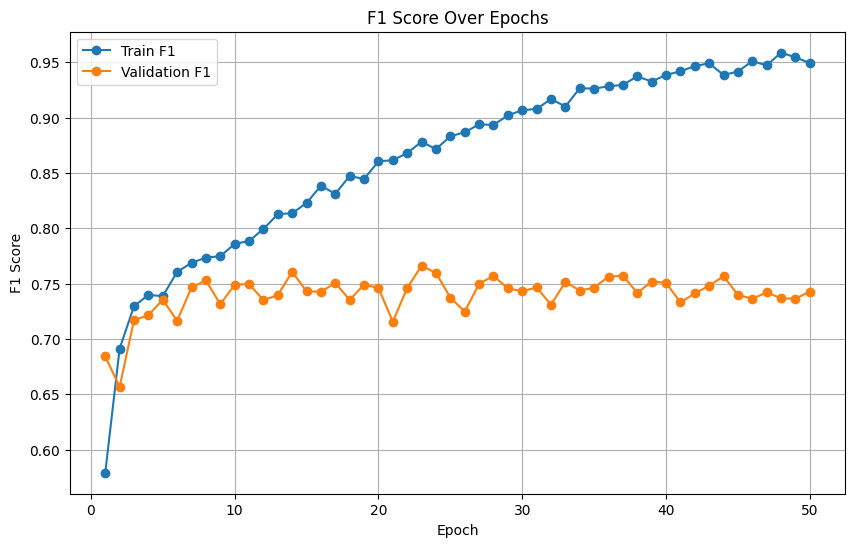

✅ F1 score plot saved at ./results/f1_scores_plot.png


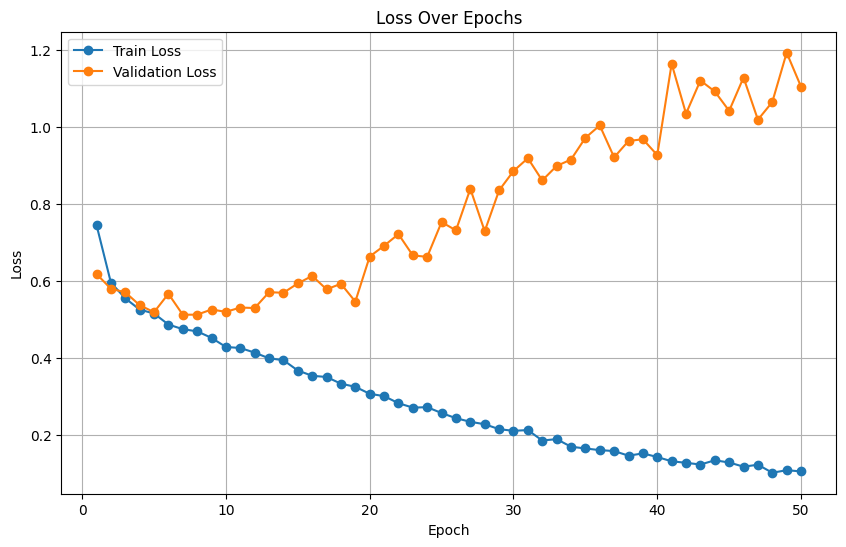

✅ Loss plot saved at ./results/losses_plot.png


In [12]:
# --- Plot F1 Scores ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_f1_scores, label='Train F1', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_f1_scores, label='Validation F1', marker='o')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'f1_scores_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ F1 score plot saved at {plot_path}")

# --- Plot Losses ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plot_path = os.path.join(OUT_DIR, 'losses_plot.png')
plt.savefig(plot_path)
plt.show()
print(f"✅ Loss plot saved at {plot_path}")

In [13]:
# load best model
# model = models.resnet18(pretrained=True)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.3),
#     nn.Linear(256, 3)
# )

model = models.swin_t(weights=weights)
model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, NUM_CLASSES)
)

model = model.to(DEVICE)
best_model_path = os.path.join(OUT_DIR, 'model_epoch_4.pth')
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model = model.to(DEVICE)

In [14]:
# --- Test Prediction ---
model.eval()
predictions = []
asset_ids = []

with torch.no_grad():
    for images, ids in tqdm(test_loader, desc="Predicting"):
        images = images.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)
        asset_ids.extend(ids.cpu().numpy())  # Convert tensor to numpy array and extend

# --- Save Submission ---
submission_df = pd.DataFrame({'id': asset_ids, 'GalaxyType': predictions})
submission_df.sort_values('id', inplace=True)
submission_df.to_csv(OUT_TEST_CSV, index=False)
print(f"Submission saved to {OUT_TEST_CSV}")
print(submission_df.head())


Predicting: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]

Submission saved to ./results/test.csv
     id  GalaxyType
133   1           2
398   2           0
348   3           2
336   4           2
35    5           0
